In this final project, available to Verified learners only, we'll attempt to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data. Smartphone accelerometers are very precise, and different physical activities give rise to different patterns of acceleration.

The input data used for training in this project consists of two files. The first file, train_time_series.csv, contains the raw accelerometer data, which has been collected using the Beiwe research platform, and it has the following format:

timestamp, UTC time, accuracy, x, y, z

You can use the timestamp column as your time variable; you'll also need the last three columns, here labeled x, y, and z, which correspond to measurements of linear acceleration along each of the three orthogonal axes.

The second file, train_labels.csv, contains the activity labels, and you'll be using these labels to train your model. Different activities have been numbered with integers. We use the following encoding: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up. Because the accelerometers are sampled at high frequency, the labels in train_labels.csv are only provided for every 10th observation in train_time_series.csv.

In [45]:
%matplotlib inline
# to fix random seeds
import random, os
# ignore warnings
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [46]:
import pandas as pd
import numpy as np
train_data1 = pd.read_csv('train_time_series.csv')
train_labels = pd.read_csv('train_labels.csv')
test_data1 = pd.read_csv('test_time_series.csv')
test_labels = pd.read_csv('test_labels.csv')
train_data2 = train_data1.iloc[3:]
train_data = train_data2.reset_index(drop=True)
train_data

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20589,1565110000000,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
1,20590,1565110000000,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
2,20591,1565110000000,2019-08-06T16:45:31.288,unknown,-0.010880,-0.967575,0.170898
3,20592,1565110000000,2019-08-06T16:45:31.388,unknown,0.052841,-0.982330,0.235565
4,20593,1565110000000,2019-08-06T16:45:31.488,unknown,0.032974,-1.053207,0.256714
...,...,...,...,...,...,...,...
3736,24325,1565110000000,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304
3737,24326,1565110000000,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213
3738,24327,1565110000000,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713
3739,24328,1565110000000,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805


In [10]:
train_labels[200:205]

,Unnamed: 0,timestamp,UTC time,label
200,22589,1565110131639,2019-08-06T16:48:51.639,2
201,22599,1565110132641,2019-08-06T16:48:52.641,2
202,22609,1565110133644,2019-08-06T16:48:53.644,2
203,22619,1565110134646,2019-08-06T16:48:54.646,2
204,22629,1565110135648,2019-08-06T16:48:55.648,2


In [15]:
train_labels['label'].value_counts()

2    213
3     88
4     47
1     27
Name: label, dtype: int64

In [31]:
for i in train_labels.index:
    train_data.loc[i*10:(i+1)*10,'timestamp'] = train_labels.loc[i,'timestamp']
    train_data.loc[i*10:(i+1)*10,'label'] = train_labels.loc[i,'label']
#train_data['timestamp'].tail()

In [32]:
times = train_data.timestamp
times_labels = train_labels.timestamp
elapsed_time = [time - times[0] for time in times]
elapsed_time_labels = [time - times_labels[0] for time in times_labels]
train_data['elapsed_time'] = pd.Series(elapsed_time, index = train_data.index)
train_labels['elapsed_time'] = pd.Series(elapsed_time_labels, index = train_labels.index)
train_data

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z,label,elapsed_time
0,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1.0,0
1,20590,1565109931087,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,1.0,0
2,20591,1565109931087,2019-08-06T16:45:31.288,unknown,-0.010880,-0.967575,0.170898,1.0,0
3,20592,1565109931087,2019-08-06T16:45:31.388,unknown,0.052841,-0.982330,0.235565,1.0,0
4,20593,1565109931087,2019-08-06T16:45:31.488,unknown,0.032974,-1.053207,0.256714,1.0,0
...,...,...,...,...,...,...,...,...,...
3736,24325,1565110305037,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304,4.0,373950
3737,24326,1565110305037,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213,4.0,373950
3738,24327,1565110305037,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713,4.0,373950
3739,24328,1565110305037,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805,4.0,373950


In [13]:
train_data.describe()

,Unnamed: 0,timestamp,x,y,z,label,elapsed_time
count,3741.000000,3.741000e+03,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000
mean,22459.000000,1.565110e+12,0.196010,-1.005267,0.084449,2.409516,187043.456830
std,1080.078006,1.082895e+05,0.395800,0.451358,0.350946,0.795479,108289.518075
min,20589.000000,1.565110e+12,-1.071152,-3.391312,-1.415390,1.000000,0.000000
25%,21524.000000,1.565110e+12,-0.021286,-1.148361,-0.068573,2.000000,93213.000000
50%,22459.000000,1.565110e+12,0.161789,-0.957932,0.052109,2.000000,187522.000000
75%,23394.000000,1.565110e+12,0.400894,-0.769669,0.203903,3.000000,280736.000000
max,24329.000000,1.565110e+12,2.503098,0.321747,2.587173,4.000000,374952.000000


In [14]:
#majority of the labels are '2'
train_data['label'].value_counts()

2.0    2130
3.0     880
4.0     461
1.0     270
Name: label, dtype: int64

In [20]:
train_data[["elapsed_time", "label"]].groupby(['elapsed_time'], as_index=False).mean().sort_values(by='label', ascending=False)

,elapsed_time,label
374,374952,4.0
116,116359,4.0
114,114355,4.0
113,113352,4.0
112,112263,4.0
...,...,...
138,138410,1.0
137,137407,1.0
136,136405,1.0
135,135403,1.0


In [26]:
train_data[["Unnamed: 0", "label"]].groupby(['Unnamed: 0'], as_index=False).mean().sort_values(by='label', ascending=False)

,Unnamed: 0,label
3740,24329,4.0
1097,21686,4.0
1088,21677,4.0
1089,21678,4.0
1090,21679,4.0
...,...,...
1437,22026,1.0
1438,22027,1.0
1439,22028,1.0
1440,22029,1.0


Text(0.5, 0, '$z_1$')

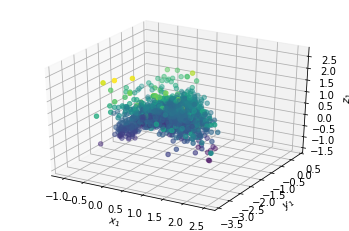

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
x1, y1, z1 = train_data.x, train_data.y, train_data.z,
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, c=z1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$y_1$')
ax.set_zlabel('$z_1$')

Activity Classification

Your goal is to classify different physical activities as accurately as possible. To test your code, you're also provided a file called test_time_series.csv, and at the end of the project you're asked to provide the activity labels predicted by your code for this test data set. Only the course staff have the corresponding true labels for the test data, and the accuracy of your code will be determined as the percentage of correct classifications. Note that in both cases, for training and testing, the input file consists of a single (3-dimensional) time series. To test the accuracy of your code, you'll be asked to upload your predictions as a CSV file. This file called test_labels.csv is provided to you, but it only contains the time stamps needed for prediction; you'll need to augment this file by adding the corresponding class predictions (1,2,3,4).

In [47]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# We fix all the random seed so that, we can reproduce the results.
seed_everything(2020)

In [33]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
X_train = train_data[["elapsed_time","Unnamed: 0","x", "y", "z"]].to_numpy()
y_train = train_data['label'].to_numpy()
print(X_train.shape)
print(y_train.shape)
clf.fit(X_train, y_train)

(3741, 5)
(3741,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
accuracy_logistic_regression = round(clf.score(X_train, y_train)*100,2)
accuracy_logistic_regression

56.94

In [37]:
clf.predict_proba(np.array([373950, 24325, 0.024384, -0.710709, 0.030304]).reshape(1, -1))

array([[0.00708992, 0.52595893, 0.38928923, 0.07766192]])

In [38]:
test_data1

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623
1,24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975
2,24332,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771
3,24333,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810
4,24334,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550
...,...,...,...,...,...,...,...
1245,25575,1565110430975,2019-08-06T16:53:50.975,unknown,0.036499,-0.724823,0.553802
1246,25576,1565110431075,2019-08-06T16:53:51.075,unknown,-0.159241,0.307022,0.142410
1247,25577,1565110431175,2019-08-06T16:53:51.175,unknown,-0.037964,-0.673706,1.065445
1248,25578,1565110431275,2019-08-06T16:53:51.275,unknown,0.255707,-1.485397,-0.013336


In [34]:
test_data1.shape

(1250, 7)

In [39]:
test_labels

,Unnamed: 0,timestamp,UTC time,label
0,24339,1565110307041,2019-08-06T16:51:47.041,NaN
1,24349,1565110308043,2019-08-06T16:51:48.043,NaN
2,24359,1565110309046,2019-08-06T16:51:49.046,NaN
3,24369,1565110310048,2019-08-06T16:51:50.048,NaN
4,24379,1565110311050,2019-08-06T16:51:51.050,NaN
...,...,...,...,...
120,25539,1565110427366,2019-08-06T16:53:47.366,NaN
121,25549,1565110428369,2019-08-06T16:53:48.369,NaN
122,25559,1565110429371,2019-08-06T16:53:49.371,NaN
123,25569,1565110430373,2019-08-06T16:53:50.373,NaN


In [37]:
test_labels.shape

(125, 4)

In [40]:
times_test = test_data1.timestamp
test_elapsed_time = [time - times_test[0] for time in times_test]
test_data1['elapsed_time'] = pd.Series(test_elapsed_time, index = test_data1.index)

In [41]:
test_data1

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z,elapsed_time
0,24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623,0
1,24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975,100
2,24332,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771,201
3,24333,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810,301
4,24334,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550,401
...,...,...,...,...,...,...,...,...
1245,25575,1565110430975,2019-08-06T16:53:50.975,unknown,0.036499,-0.724823,0.553802,124836
1246,25576,1565110431075,2019-08-06T16:53:51.075,unknown,-0.159241,0.307022,0.142410,124936
1247,25577,1565110431175,2019-08-06T16:53:51.175,unknown,-0.037964,-0.673706,1.065445,125036
1248,25578,1565110431275,2019-08-06T16:53:51.275,unknown,0.255707,-1.485397,-0.013336,125136


In [41]:
X_test = test_data1[["elapsed_time","Unnamed: 0","x", "y", "z"]].to_numpy()
#X_test

In [48]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train, y_train)
test_pred_svc = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

78.88

In [51]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
test_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

100.0

In [52]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
test_pred_gaussian = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

60.63

In [53]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
test_pred_perc = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

13.12

In [54]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
test_pred_lin_svc = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

25.93

In [55]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
test_pred_sgd = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

56.94

In [56]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
test_pred_dt = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

100.0

In [57]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
test_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

100.0

In [58]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, accuracy_logistic_regression, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,KNN,100.00
3,Random Forest,100.00
8,Decision Tree,100.00
0,Support Vector Machines,78.88
4,Naive Bayes,60.63
2,Logistic Regression,56.94
6,Stochastic Gradient Decent,56.94
7,Linear SVC,25.93
5,Perceptron,13.12


In [62]:
#use random forest calssifier to predit test data's label and append in 'test_labels.csv'
test_data1['label'] = test_pred_rf
test_data1.to_csv('harvard_final_label.csv', index=False)

In [61]:
test_data1[1200:1207]

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z,label
1200,25530,1565110426464,2019-08-06T16:53:46.464,unknown,-0.762344,-0.674561,-0.482910,4.0
1201,25531,1565110426564,2019-08-06T16:53:46.564,unknown,0.729523,-1.593307,-0.354401,4.0
1202,25532,1565110426665,2019-08-06T16:53:46.665,unknown,0.047882,-0.778229,-0.268600,4.0
1203,25533,1565110426765,2019-08-06T16:53:46.765,unknown,0.158386,-0.922073,-0.030563,4.0
1204,25534,1565110426865,2019-08-06T16:53:46.865,unknown,0.451340,-0.974747,-0.354004,4.0
1205,25535,1565110426965,2019-08-06T16:53:46.965,unknown,0.312073,-1.102081,-0.205307,4.0
1206,25536,1565110427066,2019-08-06T16:53:47.066,unknown,0.267349,-1.323608,0.317719,4.0
